# Introduction
- Compare npj results to schrodingers
    - Is the discrepancy due to choice of:
        - Functional?
        - ML-architecture?
- Sam's paper seems to suggest that:
    - MACE is more efficient in terms of data set size requirements,
    - it is possible to generate data with one ML-architecture and train a model with a different ML-architecture on that data and expect similar results, and
    - produces more reliable diffusivities and densities with low seed variability for bulk-models
- Is it possible to train MACE on clusters?
    - This would perhaps allow one to use hybrid functionals
    - We note that the Schrodiger publication had long-range interactions and a different goal than we have here, but we want to see how well it works anyway
    - We should provide examples of studies that focused on neutral systems without excplicit long-range electrostatics with a reasonable degree of success to motivate this further. Just to say something.

# Results and discussion 

In [314]:
from ase.io import read, iread

import matplotlib.pyplot as plt
import pandas as pd

dynamics_path = '../publication/dynamics/'
static_path = '../publication/static_tests/'

tmap = {
    'npt_000conEC_298K':'EMC (298$\,$K)',
    'npt_033conEC_298K':'EC:EMC (3:7) (298$\,$K)',
    'npt_066conEC_298K':'EC:EMC (7:3) (298$\,$K)',
    'npt_100conEC_313K':'EC (313$\,$K)',
}

In [ ]:
def get_all_thermo(tag):
    """This needs to be exhanged for Ioans version in order to be consistent with
    zenodo.
    """
    thermo = {}
    flist = [name for name in glob.glob(tag)]
    #for name in glob.glob(tag):
    #    print(name)
    #flist = z.read_dat_files(tag, ext='.thermo')
    for f in flist:
        #print(f)
        aux = os.path.basename(f)
        key = os.path.splitext(aux)[0]
        #print(aux,key)
        thermo.update({key: pp.loadtxttag(f)})
    return thermo

def get_dens(tags, root_path):
    thermo = dict()
    for tag in tags:
        thermo[tag] = get_all_thermo(f'{root_path}{tag}/*')
    
    densities = dict()
    for i, k in enumerate(thermo):
        tag = tags[i]
        densities[tag] = {}
        for traj_name, traj_data in thermo[k].items():
            # Collect data
            dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
            #densities[tag]['units'] = dunit
            densities[tag][traj_name] = np.mean(dens)
    return densities
    

def get_xyz(tag):
    flist = [name for name in glob.glob(tag)]
    for f in flist:
        if 'xyz' in f:
            return read(f, ':')

def RMSE(x,ref):
    se = (x-ref)**2
    mse = np.mean(se)
    rmse = mse**0.5
    rrmse = rmse*(np.mean((ref-np.mean(ref))**2))**-0.5
    return rmse, rrmse

## Cluster v. Bulk
We recompute one bulk- and one cluster data set sampled from the full Schrodinger data with B97-D3BJ. We then train two models on each, run dynamics, and compare their results. Due to the size of the cluster data set, recomputing this data set with a new functional is not really feasible. The reason for the size of this data set stems from the difficulty in making a QEq-comitte converge. Since no charges are present in this project, it should be possible to reduce the data set. To this end, the data set was (somewhat) arbitrarily reduced to consist of 25% of all neutral strucures of the full data set. 
### Force correlations
The self-correlation with the training set shows low error for the training set. Not very interesting.

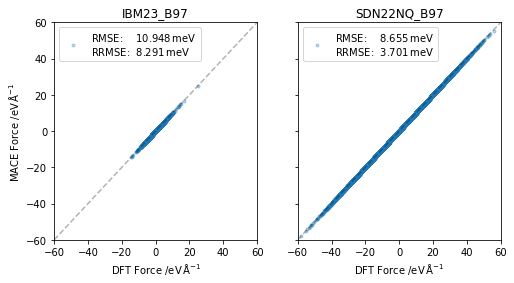

In [297]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
xyz = dict()
for tag in tags:
    xyz[tag] = get_xyz(f'{static_path}force_correlation/{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(1,2, figsize=(4*2, 4*1), sharex=True, sharey=True)
for i, k in enumerate(xyz):
    tag = tags[i]
    atoms = xyz[k]
    data_set, functional, seed, dset_sample = tag.split('/')
    
    # Obtain forces and errors
    ## reference
    ref_forces = [a.arrays['forces'] for a in atoms if 'forces' in a.arrays.keys()]
    ref_forces = np.concatenate(ref_forces).flatten()

    ## mace
    mace_forces = [a.arrays['MACE_forces'] for a in atoms if 'forces' in a.arrays.keys()]
    mace_forces = np.concatenate(mace_forces).flatten()
    rmse, rrmse = RMSE(mace_forces, ref_forces)

    # Plot correlations
    axs[i].set_title(f'{data_set}_{functional}')
    axs[i].plot(ref_forces, mace_forces, '.', label=f'RMSE:    {rmse*1e3:.3f}$\,$meV\nRRMSE:  {rrmse*1e3:.3f}$\,$meV', alpha=0.3)
    axs[i].legend(loc='upper left', numpoints=1)

    # Plot settings
    axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.3)
    axs[i].set_xlabel('DFT Force /eV$\,$Å$^{-1}$')
    axs[i].set_xlim([-60,60])
    axs[i].set_ylim([-60,60])
    if i == 0: axs[i].set_ylabel('MACE Force /eV$\,$Å$^{-1}$')
    

### Densities and diffusivites
Running molecular dynamics with the two models reveals similar behaviour between them, implying that long range-effects on the local environment may not be that important for the dynamics. Both the density and the diffusivity are on par with each other, but we note that the cluster model seems to have a softer perspective of EMC than does the periodic model. One reason for this is, possibly, the fact that EMC is less frequently observed in all but the largest ans smallest clusters wheras EC is more uniformly spread across cluster compositions. Converesly, since the periodic model has been trained on the same type of local envrironments that is obeserved in the trajectory below the spread of EMC across this data set becomes more uniform as well.

On the surface level and in terms of the diffusivity, this seems rather well correlated with the density, seeing as the main difference between the models are the somewhat lower density in the pure EMC trajectory and higher diffusivity for the cluster based model. However, a log-log plot reveals that the cluster-model is barely converged with respect to mean-squared displacements. The periodic model, on the other hand, is more stable in that regard.

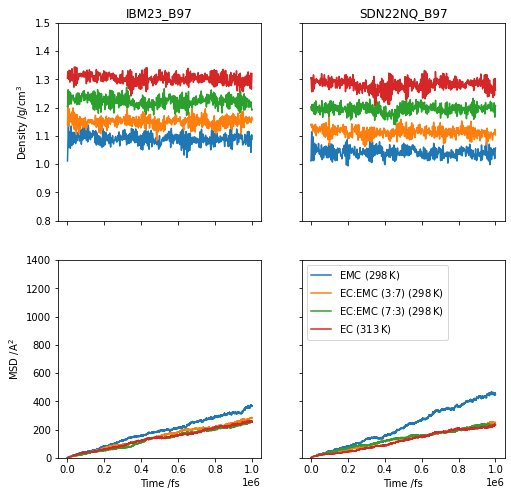

In [271]:
tags = ['IBM23/B97/SEED1/DSET1', 'SDN22NQ/B97/SEED1/DSET1'] # These tags needs to be adjusted to be compliant with zenodo

# Obtain data and store to dicts
thermo = dict()
for tag in tags:
    thermo[tag] = get_all_thermo(f'{dynamics_path}{tag}/*') # Argument should be 'tag' to be consistent with zenodo


fig, axs = plt.subplots(2,2, figsize=(4*2, 4*2), sharex=True, sharey='row')
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    #print(tag)
    #print(thermo[k].keys())
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        dens, dunit = traj_data['Density']['data'], traj_data['Density']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot density
        axs[0,i].set_ylim([0.8, 1.5])
        if i == 0: axs[0,i].set_ylabel(f'Density /{dunit}')
        axs[0,i].plot(time,dens, label=tmap[traj_name])

        # Plot MSD
        axs[1,i].set_ylim([0, 1400])
        if i == 0: axs[1,i].set_ylabel(f'MSD /{munit}')
        axs[1,i].plot(time,msd, label=tmap[traj_name])

        # Shared plot setings
        axs[0,i].set_title(f'{data_set}_{functional}')
        axs[1,i].set_xlabel(f'Time /{tunit}')
axs[-1,-1].legend(loc='upper left')

/tmp/ipykernel_408093/1163979954.py:11: UserWarning:

Attempt to set non-positive ylim on a log-scaled axis will be ignored.



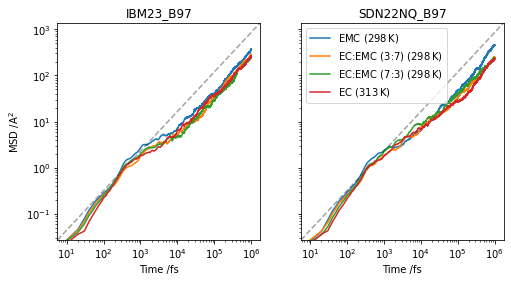

In [275]:
fig, axs = plt.subplots(1,2, figsize=(4*2, 4*1), sharey=True)
for i, k in enumerate(thermo):
    tag = tags[i]
    data_set, functional, seed, dset_sample = tag.split('/')
    for traj_name, traj_data in thermo[k].items():
        # Collect data
        time, tunit = traj_data['Time']['data'], traj_data['Time']['units']
        msd, munit = traj_data['MSD']['data'], traj_data['MSD']['units']

        # Plot MSD
        axs[i].set_ylim([0, 1400])
        if i == 0: axs[i].set_ylabel(f'MSD /{munit}')
        axs[i].plot(time,msd, label=tmap[traj_name])

        # Shared plot setings
        axs[i].plot([0, 1], [0, 1], 'k--', transform=axs[i].transAxes, alpha=0.1)
        axs[i].set_title(f'{data_set}_{functional}')
        axs[i].set_xscale('log'); axs[i].set_yscale('log')
        axs[i].set_xlabel(f'Time /{tunit}')
axs[-1].legend(loc='upper left')

### Data set size optimisation
(This is where we show how it all falls apart)

In [348]:
tags = [
    'SDN22NQQ/wB97X/SEED1/DSET1',
    'SDN22NQQ/wB97X/SEED2/DSET1',
    'SDN22NQQ/wB97X/SEED3/DSET1',
    'SDN22NQQ/wB97X/SEED1/DSET2',
    'SDN22NQQ/wB97X/SEED1/DSET2',
    'SDN22NQ/wB97X/SEED1/DSET1', 
    #'SDN22NQ/wB97X/SEED2/DSET1', # this is missing, locally (Sams)
    #'SDN22NQ/wB97X/SEED3/DSET1', # this is missing, locally (Sams)
    'SDN22NQ/wB97X/SEED1/DSET2',
    'SDN22NQ/wB97X/SEED1/DSET3',
    'SDN22N/wB97X/SEED1/DSET1',
    'SDN22N/wB97X/SEED2/DSET1',
    'SDN22N/wB97X/SEED3/DSET1',
] # These tags needs to be adjusted to be compliant with zenodo


# Compute average densities
dens = dict()
dens = get_dens(tags, dynamics_path)

# Collect average densities for all tags
data = {
    'Train data':[],
    'Functional':[],
    'Seed':[],
    'Sample':[],
    'Composition':[],
    'Avg. density':[],
}
for tag, d in dens.items():
    data_set, functional, seed, dset_sample = tag.split('/')
    seed = int(seed[-1]); dset_sample = int(dset_sample[-1])

    # Add one instance per composition
    for i in range(4):
        data['Train data'].append(data_set)
        data['Functional'].append(functional)
        data['Seed'].append(seed)
        data['Sample'].append(dset_sample)
    
    # Add average densities for each composition
    for traj_name, avg_dens in d.items():
        comp = traj_name.split('_')[1]
        data['Composition'].append(comp)
        data['Avg. density'].append(avg_dens)

df = pd.DataFrame(data)
df

,Train data,Functional,Seed,Sample,Composition,Avg. density
0,SDN22NQQ,wB97X,1,1,000conEC,1.133707
1,SDN22NQQ,wB97X,1,1,033conEC,1.205010
2,SDN22NQQ,wB97X,1,1,066conEC,1.283700
3,SDN22NQQ,wB97X,1,1,100conEC,1.379088
4,SDN22NQQ,wB97X,2,1,000conEC,1.047008
5,SDN22NQQ,wB97X,2,1,033conEC,1.116659
6,SDN22NQQ,wB97X,2,1,066conEC,1.203880
7,SDN22NQQ,wB97X,2,1,100conEC,1.300434
8,SDN22NQQ,wB97X,3,1,000conEC,1.303372
9,SDN22NQQ,wB97X,3,1,033conEC,1.351707


### Seed and data set variability

## Possible sources of error
Here we start by doing some data analysis and to look for different correlations between properties etc.

# Other questions and remarks
- Vscans for clusters, bulk and compared to DFT
    - Poor results: shows that this test is not rigorous
    - Good results: shows that this test is perhaps not a good test
- Force-correlations between models
    - Take the trajectories of each models (cluster v. bulk comparison), select a set of snapshot and recompute with B97 and do, for each model, force correlations compared with DFT reference
    - Correlate the two models, independent of DFT reference. Do a triangle-inequality check in force RMSE. Does it say anything?
- IMPORTANT: The schrodinger people systematically sampled structures that were strained or otherwise high in energy in order to have agreement across their QEq-committe. Since this is not of interest to us, it might just be that these structures are inappropriate to train a short-range model on. A different selection might have worked better!
- Check local environments. Take a model independent of any here, such as the MP0 model. Use it to generate fingerprints for the training sets (bulk and cluster) and to t-SNE test to see if they mix or not